## Importing librairies

In [1]:
import pickle
import os 
import json
import string
import requests
from IPython.display import clear_output

In [2]:
!pip install langdetect
!pip install names-dataset
!pip install bertopic
!pip install Wikidata
!pip install wordcloud
!pip install pyLDAvis
!pip install NRCLex
clear_output()

In [3]:
#EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from wikidata.client import Client
from tqdm import tqdm
from collections import Counter

#Preprocessing
from langdetect import detect
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from names_dataset import NameDataset
from itertools import chain 
import seaborn as sns

#Stats
import scipy.stats as stats

#LDA
from gensim.models import Phrases
from gensim import corpora
from gensim import models

#WordCloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Topic visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

#BERTopic
from bertopic import BERTopic

#Sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()
clear_output()

In [5]:
from nltk import download
download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')
download('stopwords')
clear_output()

## References

[[1]](http://www.cs.cmu.edu/~ark/personas/) CMU Movie Summary Corpus webpage  
[[2]](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf) _Learning Latent Personas of Film Characters_, David Bamman, Brendan O'Connor and Noah A. Smith, ACL 2013, Sofia, Bulgaria, August 2013 \
[[3]](https://www.nltk.org/) NLKT documentation 

# Table of contents
### [1. Metadata](#1)

&nbsp;&nbsp;&nbsp;**[1.1 The data](#1.1)**

&nbsp;&nbsp;&nbsp;**[1.2 Cleaning the dictionaries](#1.2)**

&nbsp;&nbsp;&nbsp;**[1.3 Duplicate values](#1.3)**

&nbsp;&nbsp;&nbsp;**[1.4 Missing values](#1.4)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.1 Recovering Ethnicities](#1.4.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.2 Recovering missing Actor names ](#1.4.2)


### [2. Plot Summaries and Metascores](#2)

&nbsp;&nbsp;&nbsp;**[2.1 Preprocessing](#2.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 Missing plot summaries check](#2.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 Cleaning](#2.1.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.3 Tokenization](#2.1.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.4 PoS tagging](#2.1.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.5 Lemmatization](#2.1.5)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.6 Regrouping tokens and removing stop words](#2.1.6)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.7 Integration into movies dataset ](#2.1.7)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.8 Preprocessing results](#2.1.8)

&nbsp;&nbsp;&nbsp;**[2.2 Importing Metascore](#2.2)**

&nbsp;&nbsp;&nbsp;**[2.3 Initial analysis](#2.3)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 Plot summaries structure](#2.3.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 Most common tokens](#2.3.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 Movie genres clustering](#2.3.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.4 Words polarity](#2.3.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.5 Ratings preliminary visualization](#2.3.5)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.6 WordCloud](#2.3.6)

### [3. Topic extraction](#3)

&nbsp;&nbsp;&nbsp;**[3.1 LDA](#3.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Data preparation](#3.1.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Implementation](#3.1.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.3 Model evaluation](#3.1.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.4 Resulting topics](#3.1.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.5 Topic Visualizations](#3.1.5)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.6 Assigning topics to movies](#3.1.6)

&nbsp;&nbsp;&nbsp;**[3.2 BERTopic](#3.2)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1 Implementation](#3.2.1)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2 Model evaluation](#3.2.2)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.3 Resulting topics](#3.2.3)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.4 Topic Visualizations](#3.2.4)\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.5 Assigning topics to movies](#3.2.5)

### [4. Sentiment analysis](#4)


# 1. Metadata <a id='1'></a>

## 1.1 The Data  <a id='1.1'></a>

`movie.metadata.tsv.gz` [3.4 M]


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`character.metadata.tsv.gz` [14 M]

Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [10]:
movies_path = "data/movie.metadata.tsv"
characters_path = "data/character.metadata.tsv"

# naming the columns with adequate names
movies_column_names = ["WikiMovieID", "FreeMovieID", "Title", "ReleaseDate", "Revenue", "Runtime", "Languages", "Countries", "Genres"]
characters_column_names = ["WikiMovieID", "FreeMovieID", "ReleaseDate", "CharName", "ActorDOB", "ActorGender", "ActorHeight", "FreeEthnicityID",\
                           "ActorName", "ActorAgeRelease", "FreeMapID", "FreeCharID", "FreeActorID"]

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)

display(movies.head())
display(characters.head())

WikiMovieID FreeMovieID                                              Title  \
0       975900   /m/03vyhn                                     Ghosts of Mars   
1      3196793   /m/08yl5d  Getting Away with Murder: The JonBenét Ramsey ...   
2     28463795  /m/0crgdbh                                        Brun bitter   
3      9363483  /m/0285_cd                                   White Of The Eye   
4       261236   /m/01mrr1                                  A Woman in Flames   

  ReleaseDate     Revenue  Runtime                           Languages  \
0  2001-08-24  14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1  2000-02-16         NaN     95.0  {"/m/02h40lc": "English Language"}   
2        1988         NaN     83.0  {"/m/05f_3": "Norwegian Language"}   
3        1987         NaN    110.0  {"/m/02h40lc": "English Language"}   
4        1983         NaN    106.0   {"/m/04306rv": "German Language"}   

                                   Countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                              Genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
4                            {"/m/07s9rl0": "Drama"}

WikiMovieID FreeMovieID ReleaseDate                    CharName  \
0       975900   /m/03vyhn  2001-08-24                    Akooshay   
1       975900   /m/03vyhn  2001-08-24  Lieutenant Melanie Ballard   
2       975900   /m/03vyhn  2001-08-24         Desolation Williams   
3       975900   /m/03vyhn  2001-08-24          Sgt Jericho Butler   
4       975900   /m/03vyhn  2001-08-24             Bashira Kincaid   

     ActorDOB ActorGender  ActorHeight FreeEthnicityID           ActorName  \
0  1958-08-26           F        1.620             NaN      Wanda De Jesus   
1  1974-08-15           F        1.780      /m/044038p  Natasha Henstridge   
2  1969-06-15           M        1.727         /m/0x67            Ice Cube   
3  1967-09-12           M        1.750             NaN       Jason Statham   
4  1977-09-25           F        1.650             NaN         Clea DuVall   

   ActorAgeRelease   FreeMapID  FreeCharID FreeActorID  
0             42.0  /m/0bgchxw  /m/0bgcj3x  /m/03wcfv7  
1             27.0   /m/0jys3m  /m/0bgchn4   /m/0346l4  
2             32.0   /m/0jys3g  /m/0bgchn_  /m/01vw26l  
3             33.0  /m/02vchl6  /m/0bgchnq   /m/034hyc  
4             23.0  /m/02vbb3r  /m/0bgchp9   /m/01y9xg

#### Initial remarks :
- `ReleaseDate`doesn't have a standard format.
- `Languages`, `Countries`and `Genres`columns have their values in a dictionary of form : `{Freebase id : Actual name}`

#### Dataset length
We verify that the given dataset entries are indeed as much as we expect : 

In [ ]:
n_mov = len(movies)
n_char = len(characters)
print('Number of rows in the movie.metadata dataset :', n_mov)
print('Number of rows in the character.metadata dataset :', n_char)

## 1.2 Cleaning Dictionaries  <a id='1.2'></a>

Columns `Languages`, `Countries`, `Genres` are dictionaries containing both the Freebase ID and the actual name, for each entry. We will keep only the names for the sake of clarity.

In [ ]:
def extract_values(column):
    values = []
    column=json.loads(column)
    for key in column:
        values.append(column[key])
    return values

movies.Languages = movies.Languages.apply(extract_values)
movies.Countries = movies.Countries.apply(extract_values)
movies.Genres = movies.Genres.apply(extract_values)

display(movies[["Languages", "Countries", "Genres"]].head())

## 1.3 Duplicate values  <a id='1.3'></a>

Starting with the characters dataset we only care if a whole row is duplicated as there is no specific feature that we prohibit from happenning twice.

In [ ]:
print("Duplicated rows in characters : {}".format(characters.duplicated().sum()))

As for the movies dataset we have to be more careful as we don't want the same movie appearing twice under different release date or freebase id for example.

In [ ]:
print("Duplicated rows in :")
for column in movies.columns:
    duplicated_rows = movies[column].duplicated().sum()
    print("\t{} : {} ".format(column, duplicated_rows))

The fact that `Title` has a duplicated rows is a bit concerning. We see however than `WikiMovieID` and movies `FreeMovieID` have only unique entries. This indicates us that movies can have the same title while being actually different movies.

## 1.4 Missing values  <a id='1.4'></a>

We want to see which columns have missing entries, and for those columns what is the percentage of missing entries.

In [ ]:
movies.isna().any()

For the movies dataset, only `ReleaseDate`, `Revenue` and `Runtime` have missing entries.

In [ ]:
mov_missing = movies[['ReleaseDate', 'Revenue', 'Runtime']].isna().sum()
print('Percentage of missing entries in the movie dataset (%):')
for x in range(len(mov_missing.values)):
    print("   ",mov_missing.index[x], ':', round(100*mov_missing.values[x]/n_mov, 2))

90% of the revenues are non specified. We won't use this feature in our project.  
8% of the release dates and 25% of the runtimes are missing, we can fill them if we find the correct ones.

In [ ]:
characters.isna().any()

In [ ]:
char_missing = characters[['ReleaseDate', 'CharName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'FreeEthnicityID', 'ActorName',
                           'ActorAgeRelease', 'FreeCharID', 'FreeActorID']].isna().sum()
print('Percentage of missing entries in the characters dataset (%):')
for x in range(len(char_missing.values)):
    print("   ",char_missing.index[x], ':', round(100*char_missing.values[x]/n_char, 2))

### 1.4.1 Recovering Ethnicities  <a id='1.4.1'></a>

`Ethnicity` only has the ID of the Freebase database whose API is currently depreciated. To solve this problem we use the [Freebase/Wikidata Mappings](https://developers.google.com/freebase#freebase-wikidata-mappings) which as the name suggests maps the given Freebase Ids to WikiData.

- Note : The data has been created based on the Wikidata-Dump of October 28, 2013, and contains only those links that have at least two common Wikipedia-Links and not a single disagreeing Wikipedia-Link. Since the movies/characters dataset were gathered during that time too there is no time conflict.

In [ ]:
mappings_path = "data/fb2w.nt.gz"
maps = pd.read_csv(mappings_path, sep='\t', header=None, skiprows=4, names=["Freebase", "W3", "Wiki"])
display(maps.head())

We only need the ID and not the whole website link so we transform columns in the following way :
- Freebase : <http://rdf.freebase.com/ns/m.CODE_ID> -> /m/CODE_ID
- Wiki : <http://www.wikidata.org/entity/CODE_ID> -> CODE_ID

In [ ]:
"""
Transforms the Freebase website to Freebase ID
"""
def elim_freebase(web):
    return "/m/"+web[30:-1]

"""
Transforms the Freebase website to Freebase ID
"""
def elim_wiki(web):
    return web[32:-3]

In [ ]:
maps["free"] = maps.Freebase.apply(elim_freebase)
maps["wiki"] = maps.Wiki.apply(elim_wiki)

# We don't need the rest of the columns so we drop them 
maps.drop(columns = ["Freebase", "W3", "Wiki"], inplace=True)
maps.head()

Firstly, we get the Wikidata IDs based on the mapping we created :

In [ ]:
characters = characters.merge(maps, how="left", left_on="FreeEthnicityID", right_on="free")
characters.drop(columns=["free"], inplace=True)
characters.rename(columns={"wiki":"Ethnicity_W"}, inplace=True)
display(characters.head())

As we can see the mapping is not complete : Some Freebase IDs do not correspond to any Wikidata ID. 

In [ ]:
unmapped_ethnicities = characters.Ethnicity_W.isna().sum() - characters.FreeEthnicityID.isna().sum()
print("There are {} instances of ethnicities that we could not map from Freebase to Wikidata".format(unmapped_ethnicities))
# Instances of ethnicities -> Can we replace by number of actors ethnicities? Actors with different initial ethnicities ?

In [ ]:
"""
Given a Wikidata ID (eg. "Q49085") returns the corresponding label 

Using this function row by row (pd.apply method) takes enormous time -> improvement? For ethnicities its ok as they're only 350 dinstinct ones
"""
def get_wikidata_label(wikidata_id):
    client = Client()
    entity = client.get(wikidata_id, load=True)
    return str(entity.label)

In [ ]:
# Result is map_Ethnicity_W_to_Ethnicity_name a map between Ethnicity wikidata ID and Ethnicity label
map_Ethnicity_W_to_Ethnicity_name = pd.DataFrame(characters.Ethnicity_W.unique(), columns=["Ethnicity_W"]).dropna()

# Getting the equivalent label for each Wikidata ID
map_Ethnicity_W_to_Ethnicity_name["EthnicityName"] = map_Ethnicity_W_to_Ethnicity_name.Ethnicity_W.apply(get_wikidata_label)

In [ ]:
# Assigining the missing ethnicities
characters = characters.merge(map_Ethnicity_W_to_Ethnicity_name, how="left", left_on="Ethnicity_W", right_on="Ethnicity_W").drop(columns= ["FreeEthnicityID", "Ethnicity_W"])
display(characters.head())

In [ ]:
ethn_len = characters.EthnicityName.nunique()
print("Number of unique ethnicities : {}".format(ethn_len))

The whole ethnicities plot (355 different ethnicities) was not really readable, so we plotted what are the most present ones.

In [ ]:
# Ethnicities visualization
plt.figure(figsize=(10,5))
characters.EthnicityName.value_counts()[:20].plot(kind="bar")
plt.xlabel('Ethnicities')
plt.ylabel('Number of actors')
plt.title('Distribution of the twenty most represented ethnicities');

In [ ]:
print('The percentage of missing Ethnicity names is :', round(100*characters[['EthnicityName']].isna().sum().values[0]/n_char,2), '%')

We only have the names of 20% of the actor ethnicities : this is not enough to base our analysis and to draw conclusions. We thus decided to not use the Ethnicity in our project.

### 1.4.2 Recovering Missing Actor Names  <a id='1.4.2'></a>

In addition, some actors do not have their name and/or date of birth and/or sex specified but the actor freebase ID is present. We can use the actor freebase ID to recover their Wikidata information. This gives us access to the following relevant information about the actor :
- Name
- Sex/Gender
- Date of Birth  
We can therefore replace the missing values in those categories, when the Actor Freebase ID is specified.

In [ ]:
print('Number of rows where:\n\tActor is missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and DOB are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor, DOB and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tGender is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB and Gender are missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'] & ~characters['FreeActorID'].isna())]))

#### Starting with recovery of missing Actor names

For this, we perform the same as in the Ethnicity names recovery.

In [ ]:
characters = characters.merge(maps, how="left", left_on="FreeActorID", right_on="free")
characters.drop(columns=["FreeActorID"], inplace=True)
characters.rename(columns={"wiki":"WikiActorID"}, inplace=True)
display(characters.head())

In [ ]:
missing_actor = characters[(characters['ActorName'].isna() & ~characters['WikiActorID'].isna())]

In [ ]:
map_WikiActorId_Actor = pd.DataFrame(missing_actor.WikiActorID.unique(), columns=["WikiActorID"]).dropna()
map_WikiActorId_Actor["ActorName"] = map_WikiActorId_Actor.WikiActorID.apply(get_wikidata_label)

In [ ]:
characters = characters.merge(map_WikiActorId_Actor, how="left", left_on="WikiActorID", right_on="WikiActorID").drop(columns= ["WikiActorID", "WikiActorID"])
characters.drop(columns="free", inplace=True)

In [ ]:
characters["ActorName"] = characters.fillna(value={"ActorName_x":""}).ActorName_x + characters.fillna(value={"ActorName_y":""}).ActorName_y
characters.drop(columns=["ActorName_x", "ActorName_y"], inplace=True)

In [ ]:
characters.head()

From wikidata actor page,
- sex/gender (P21) is given as : male (Q6581097), female (Q6581072), intersex (Q1097630), transgender female (Q1052281), transgender male (Q2449503).
- date of birth (P569) is given as : Day of the month as a zero-padded decimal number, blank space, Month full name, blank space, Year with century as a decimal number. To recover the date of birth in the same format as the ones in the characters dataset, we must read the date given by wikidata without the blank spaces and then use datetime to format it correctly. See example just below :

In [ ]:
wiki_date = '26 December 1949'
no_space = wiki_date.replace(" ", "")
date = datetime.strptime(no_space, '%d''%B''%Y')
formated_date = '{:%Y-%m-%d}'.format(date)
print(formated_date)

We later decided that we won't use the actors information, so we didn't push further and didn't recover missing DOB or genders.

### Saving augmented characters dataset

Extracting from wikidata takes a few minutes so we can save our final `characters` dataframe in case we want to use that directly in further applications.

In [ ]:
os.makedirs('data', exist_ok=True)  
characters.to_csv('data/characters_aug.tsv', sep="\t", index=False)

# 2. Plot Summaries   <a id='2'></a>

The plot summaries are loaded from the file `plot_summaries.txt` and stored into `plot_summaries`dataset. 

In [11]:
plot_summaries = pd.read_csv('data/plot_summaries.txt', sep="\t", header=None,names=["WikiMovieID", "Plot"])
plot_summaries.head(3)

WikiMovieID                                               Plot
0     23890098  Shlykov, a hard-working taxi driver and Lyosha...
1     31186339  The nation of Panem consists of a wealthy Capi...
2     20663735  Poovalli Induchoodan  is sentenced for six yea...

## 2.1 Preprocessing  <a id='2.1'></a>

### 2.1.1 Missing plot summaries check  <a id='2.1.1'></a>

In [ ]:
print('Number of missing plot summary in the plot_summary dataset: {}'.format(plot_summaries.Plot.isna().sum()))

In [ ]:
print('Number of missing plot summary when matched to films in movies dataset: {:.2f}%'.format((movies.merge(plot_summaries, how="left", on='WikiMovieID')).Plot.isna().sum()/len(movies)*100))

We can see that we don't have the plot summary for about half of the movies.

### 2.1.2 Cleaning <a id='2.1.2'></a>

We detect the langage used in the plot summary and keep only the ones written in English.

In [ ]:
plot_summaries['lang'] = plot_summaries.Plot.progress_apply(detect)

In [ ]:
plot_summaries.lang.value_counts()

In [ ]:
plot_summaries = plot_summaries.loc[plot_summaries.lang=='en']

### 2.1.3 Tokenization <a id='2.1.3'></a>

Tokenizers are used to divide strings into lists of substrings. For each `Plot` in `plot_summaries` dataset, a list of words and punctuation marks stored in the `words_punc` column, a list of sentences in `sentences` and a list of tokenized sentences `tokens_sentences`. To do so, we use the natural langage processing library `NLTK` (Natural Language Toolkit). "NLTK is a leading platform for building Python programs to work with human language data"[[3]](https://www.nltk.org/).

In [ ]:
plot_summaries['words_punc'] = plot_summaries.Plot.progress_apply(lambda x: word_tokenize(x))
plot_summaries['sentences'] = plot_summaries.Plot.progress_apply(lambda x: sent_tokenize(x))
plot_summaries['tokens_sentences'] = plot_summaries['sentences'].progress_apply(lambda sentences: [word_tokenize(sentence) for sentence in sentences])

### 2.1.4 PoS tagging <a id='2.1.4'></a>

Part-of-speech (POS) tagging is a popular Natural Language Processing process which refers to categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context. POS tags from the [*Penn Treebank* tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) are used to describe the lexical terms that we have within our plots.

In [ ]:
plot_summaries['POS_tokens'] = plot_summaries['tokens_sentences'].progress_apply(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])

plot_summaries['POS_tokens'].head(3)

### 2.1.5 Lemmatization <a id='2.1.5'></a>

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. It links words with similar meanings to one word. 

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [ ]:
lemmatizer = WordNetLemmatizer()

# Lemmatizing each word with its POS tag, in each sentence
plot_summaries['tokens_sentences_lemmatized'] = plot_summaries['POS_tokens'].progress_apply(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

plot_summaries[['Plot','tokens_sentences_lemmatized']].head(3)

### 2.1.6 Grouping tokens and removing stop words <a id='2.1.6'></a>

In order to extact interesting information from the words present in the plot summaries, we have to take into account only the meaningful words by removing insignificant ones called stop words.
What we have seen is that the names of the characters in the plot summaries create a lot of unwanted noise which in turn disturbs greatly our results in the topic extraction methods.Therefore, we introduce the [name-dataset](https://pypi.org/project/names-dataset/), which used a Facebook dump to create a first and last name database. From there  we extract the top 2000 first names and use them as stopwords. 

In [ ]:
nd = NameDataset()
names = nd.get_top_names(n=2000, country_alpha2="US")
names = names["US"]["M"] + names["US"]["F"]
names = [name.lower() for name in names]

In [ ]:
# Words gathered after running the LDA model and collecting the words appearing in more than 4 topics 
stops = ["one", "two", "also", "see", "take", "get", "find", "try", "however", "go", "come", "leave", "become", "make", "back", "run"]
my_stopwords = stopwords.words('english') + names + stops

plot_summaries['tokens'] = plot_summaries['tokens_sentences_lemmatized'].progress_apply(lambda sentences: list(chain.from_iterable(sentences)))

In [ ]:
plot_summaries['tokens'] = plot_summaries['tokens'].progress_apply(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

Another idea, would be to use PoS tagging to remove the all names from the plots instead of using the name-dataset. For example names that are not recognized using the name-dataset would be recognized using proper noun tags (NNP and NNPS).

Saving plot summaries dataframe to access it later without performing again the previous steps:

In [ ]:
plot_summaries.to_pickle('data/plot_summaries_aug.pkl')

### 2.1.7 Integration into movies dataset <a id='2.1.7'></a>

In [ ]:
plot_summaries = pd.read_pickle('data/plot_summaries_aug.pkl')

The preprocessed plot summaries `plot_summaries` are added to the `movies` dataset according to the Wikipedia movie ID, `WikiMovieID`. 

In [ ]:
movies = movies.merge(plot_summaries, how="left", on='WikiMovieID') 

#### Missing values

In part 2.1.1, we see that there is nearly half of the movies that has missing plot summaries. At this stage, we are interested in the plot summaries content so we remove the rows with missing plot summaries in `movies` dataset.

In [ ]:
movies = movies.dropna(subset=['Plot'])

In [ ]:
print('Length of movies dataset: {}'.format(len(movies)))

### 2.1.8 Preprocessing results <a id='2.1.8'></a>

In [ ]:
movies[['Plot','words_punc','sentences','tokens_sentences','tokens']].head(3)

In [ ]:
print(movies['Plot'][0])

In [ ]:
print(movies['POS_tokens'][0])

In [ ]:
print(movies['tokens_sentences_lemmatized'][0])

In [ ]:
print(movies['tokens'][0])

## 2.2 Importing Metascore  <a id='2.2'></a>

When considering film rating, we can think about using the IMDb database. In particular, it provides the variable `averageRating` which is the weighted average of all the individual user ratings. However, IMDb user opinions can be given whenever the user wants. So, the ratings of IMDb do not match with the release date of the movie. It only works for analyzing the current opinions, as very recent reviews and can be written for an old film. 

In order to have an insigth into the movie impression at a time closer to the release date, we can consider metascore. [Metascore](https://github.com/miazhx/metacritic) is a weighted average of reviews from top published critic reviews for a given movie, and thus does not include any votes or comments from our users.


#### Metacritic dataset loading

We use a dataset which brings together the film title, release date, metascore and other scores. We load it and add the `metascore` information into the `movie` dataset.

In [ ]:
metacritic_url = "https://raw.githubusercontent.com/miazhx/metacritic/master/data/metacritic_movies.csv"

metacritic = pd.read_csv(metacritic_url)

In [ ]:
metacritic.head()

In [ ]:
print('Number of rows in metacrtic dataset: {}'.format(len(metacritic)))

#### Missing value check

In [ ]:
print('Number of missing metascore in metacritic dataset: {}'.format(metacritic['metascore'].isna().sum()))

In [ ]:
print('Number of missing title in metacritic dataset: {}'.format(metacritic['movie_title'].isna().sum()))

In [ ]:
print('There are {} metascores for {} movies with plot summary available.'.format(len(metacritic),len(movies)))

#### Integration of metascores to `movies` dataset

In `metacritic` data set we are only interested in ratings for now. For each movie, we want to add the corresponding metascore if available. Unfortunately the `metacritic` data set does not have WikiID or unique identifier for the movie. Also, titles are not unique so we cannot match the two datasets according to this feature. One option is to match the data according to the title and the release date. In `metacritic` the release year is given by only 2 digits. So the data are matched in an non optimal way by comparing the title and the two last digits of the year.

In [ ]:
#Get informative subdataset, convert release date to datetime
metacritic_score = metacritic[['movie_title','metascore','release_date']].rename(columns = {'movie_title':'Title'})
metacritic_score['release_date_'] = pd.to_datetime(metacritic_score['release_date'], format='%d-%b-%y')

In [ ]:
#Get the two last digits, trying to deal with the misconvertion of years due to the initial format with only two digits for the year
metacritic_score['year_last_digits'] = metacritic_score['release_date_'].apply( lambda x: int(x.year-100) if (x.year >2022) else int(x.year))
metacritic_score['year_last_digits'] = metacritic_score['year_last_digits'].apply( lambda x: x-2000 if (x > 1999) else x-1900)

In [ ]:
#Get the two last digits of the year in movies dataset
movies['ReleaseDate_'] = pd.to_datetime(movies['ReleaseDate'], format="%Y-%m-%d", errors="coerce").fillna(pd.to_datetime(movies['ReleaseDate'], format="%Y", errors="coerce"))
movies['year_last_digits'] = movies['ReleaseDate_'].apply( lambda x: int(str(x.year)[2:4]) if ( pd.notnull(x) ) else x)
movies[['ReleaseDate_','year_last_digits']].head()

In [ ]:
metacritic_score.head()

Adding metascores to the `movies` dataset by merging on `Tilte`and release year.

In [ ]:
movies = movies.merge(metacritic_score[['Title','metascore','year_last_digits']], how="left", on=['Title','year_last_digits'] ) 

In [ ]:
movies.head()

In [ ]:
print('We were able to retreive {} metascores.'.format(len(movies)-movies.metascore.isna().sum()))

In [ ]:
print("Missing metascores in movies dataset: {:.2f}%".format(movies['metascore'].isna().sum()/len(movies)*100))

With 9121 metascores initially, we could have hoped to have about 20% of our movies with plot augmented with metascores. In the end, we only managed to match half of these metascores which represents about 10% of the movies with plot summaries available.  
This result is not entirely satisfying because a lot of metascores are missing. If we want to increase this percentage, we should fetch data from the web (IMDb website has metascores), we will see this in Milestone 3.

## 2.3 Initial analysis  <a id='2.3'></a>

### 2.3.1 Plot structure <a id='2.3.1'></a>

Here, for each plot summary, we investigate the number of sentences, number of words, numbers of the different punctuation marks.

We add new columns to the `movies` dataframe by counting, in each plot summary, the number of sentences, words and punctuation marks.

In [ ]:
movies['plot_num_sentences'] = movies.sentences.apply( lambda x: len(x))
movies['plot_num_words'] =  movies.Plot.apply( lambda x: len(RegexpTokenizer(r'\w+').tokenize(x)))
movies['plot_num_dot'] = movies.words_punc.apply( lambda x: list(x).count('.'))
movies['plot_num_coma'] = movies.words_punc.apply( lambda x: x.count(','))
movies['plot_num_interrogation'] = movies.words_punc.apply( lambda x: x.count('?'))
movies['plot_num_exclamation'] = movies.words_punc.apply( lambda x: x.count('!'))
movies['plot_num_percentage'] = movies.words_punc.apply( lambda x: x.count('%'))
movies['plot_num_semicolon'] = movies.words_punc.apply( lambda x: x.count(';'))
movies['plot_num_colon'] = movies.words_punc.apply( lambda x: x.count(':'))

movies[['plot_num_sentences','plot_num_words','plot_num_dot','plot_num_coma','plot_num_interrogation',\
        'plot_num_exclamation','plot_num_percentage','plot_num_semicolon','plot_num_colon']].head()

#### 2.3.1.1 Statistics

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
movies[['plot_num_sentences','plot_num_words','plot_num_dot','plot_num_coma','plot_num_interrogation',
        'plot_num_exclamation','plot_num_percentage','plot_num_semicolon','plot_num_colon']].describe()

#### 2.3.1.2 Visualizations

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
fig.tight_layout(pad=3)
axs[0].hist(movies.plot_num_sentences,bins=40,log=True)
axs[0].set_title('Distribution of sentences number \nacross plot summaries')
axs[0].set_xlabel('Number of sentences')
axs[0].set_ylabel('Counts (log)')

axs[1].hist(movies.plot_num_words,bins=40,log=True)
axs[1].set_title('Distribution of words number \nacross plot summaries')
axs[1].set_xlabel('Number of words')
axs[1].set_ylabel('Counts (log)')

plt.show()

In [ ]:
punctuation1 = movies[['plot_num_coma','plot_num_dot']]
punctuation1.plot.hist(bins=40, log=True, alpha=0.5, figsize = (8,6))
plt.title('Distribution of coma and dot number across plot summaries')
plt.xlabel('Number of punctuation mark')
plt.ylabel('Counts (log)')
plt.show()

In [ ]:
punctuation2 = movies[['plot_num_semicolon','plot_num_colon','plot_num_exclamation','plot_num_percentage','plot_num_interrogation']]
punctuation2.plot.hist(bins=40, log=True, alpha=0.5, figsize = (8,6))
plt.title('Distribution of exclamation points, interrogation points, semicolon, colon, \nand percent symbol number across plot summaries')
plt.xlabel('Number of punctuation mark')
plt.ylabel('Counts (log)')
plt.show()

We observe in general that punctuation distributions follow a heavy-tailed distribution.

### 2.3.2 Most common tokens in plot summaries <a id='2.3.2'></a>

In [ ]:
"""
Find the n most common elment of a list
Inputs: 
     n[int]: number of most common elements
     List of interest
Ouptuts:
    List of n tuples liking the element and its number of occurence(s)
"""
def most_frequent(List,n):
    occurence_count = Counter(List)
    return occurence_count.most_common(n)

In each plot, the ten most used tokens are represented in the dataframe as a pair of token and its occurence.

In [ ]:
movies['plot_top_ten_tokens'] = movies.tokens.apply( lambda x: most_frequent(x,10))

movies['plot_top_ten_tokens'].head() 

For the analysis of the most used token accross genre, we will remove the occurence.

In [ ]:
"""
Transform a list provided by the function "most_frequent"
Inputs: 
     List of tuples (element, occurence)
Ouptuts:
    List of element without occurence
"""
def remove_nb_usage(list_tokens):
  # to remove the number of occurence of the 10 most used tokens
    clean_tokens = []
    for pair in list_tokens:
        clean_tokens.append(pair[0])
    return clean_tokens

In [ ]:
movies['clean_top_ten_tokens'] = movies['plot_top_ten_tokens'].apply(remove_nb_usage)

In [ ]:
movies['clean_top_ten_tokens'].head(3)

### 2.3.3 Movie genres clustering <a id='2.3.3'></a>

In the future, we would like to match movie genres with most used tokens, to see if some tokens are repeated. This analysis won't be performed in Milestone3, but could be a good lead for Milestone3. For now, we begin with a raw clustering of movie genres.

In the movies dataframe, `Genres` is usually a list with multiple genres or subgenres. First, we extract each individual genres. 

In [9]:
"""
Get each element from lists inside of a pandas Series
"""
def to_1D(series):
    return pd.Series([x for list_ in series for x in list_])

In [10]:
pd.set_option('display.max_rows', None)
individual_genres = to_1D(movies['Genres'])
print(individual_genres.value_counts().index.tolist())

['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror', 'Black-and-white', 'Indie', 'Action/Adventure', 'Adventure', 'Family Film', 'Short Film', 'Romantic drama', 'Animation', 'Musical', 'Science Fiction', 'Mystery', 'Romantic comedy', 'Fantasy', 'Comedy film', 'Crime Thriller', 'War film', 'Period piece', 'Japanese Movies', 'Comedy-drama', 'Film adaptation', 'Documentary', 'Silent film', 'Psychological thriller', 'Bollywood', 'Western', 'Chinese Movies', 'Black comedy', 'Teen', 'LGBT', 'Parody', 'Family Drama', "Children's/Family", 'Coming of age', 'Martial Arts Film', 'Cult', 'Sports', 'Television movie', 'Slasher', 'Suspense', 'Biographical film', 'Biography', 'Supernatural', 'Satire', 'Political drama', 'Film noir', 'Slapstick', 'Melodrama', "Children's", 'Action Thrillers', 'Crime Drama', 'B-movie', 'Costume drama', 'Biopic [feature]', 'History', 'Music', 'Art film', 'Ensemble Film', 'Creature Film', 'Spy', 'Gangster Film', 'Buddy film

In [11]:
print('There are', len(individual_genres.value_counts()), 'unique genres.')

There are 363 unique genres.


For visualization purpose, we won't use the 363 different genres for now.  

For now, we will create bigger theme/genre clusters.   Disclaimer : This is a first, raw extraction of bigger movie theme/genre, to have some insights about movie genres. However his grouping is not exhaustive and as not complete, may lead to bias in interpretation.

To do so, we create 24 big clusters. A first cluster list will contain keywords that are present in the genre name. Then, we search if a genre is present in a cluster and add it to a final cluster list, that will contain the actual genre names.

In [12]:
# lists containing cluster keywords 
comedy = ['comedy', 'comedies', 'humour', 'satire', 'parody', 'bloopers',\
          'gross', 'slapstick']
drama = ['drama', 'tragedy']
horror = ['horror', 'haunted', 'demonic', 'escape', 'splatter']
romance = ['romance', 'romantic']
criminal = ['thriller', 'crime', 'detective', 'gangset', 'criminal', 'giallo',\
            'heist', 'neo-noir', 'film noir'] 
action_adventure = ['action', 'adventure', 'war', 'spy', 'ninja', 'martial',\
                    'tokusatsu', 'outlaw', 'combat', 'buddy', 'biker', 'epic',\
                     'swashbuckler'] 
entertainment_hobby = ['family', 'children', 'sport', 'baseball', 'dance',\
                       'holiday', 'christmas', 'party', 'hip hop', 'beach']
fiction = ['fiction', 'fictional', 'dystopia', 'future noir']
erotism = ['erotic','pornography', 'erotica', 'adult', 'porn', 'homoeroticism',\
           'pinku']
sci_fi = ['science fiction', 'sci-fi', 'alien', 'supernatural', 'time travel',\
          'space opera']
animation = ['animation', 'anime', 'animated']
musical = ['musical', 'music', 'concert', 'operetta', 'film-opera']
fantasy = ['fantasy', 'fantasies', 'superhero', 'werewolf', 'sorcery', 'fairy',\
           'vampire', 'creature', 'zombie', 'monster', 'sword and sandal']
western = ['western', 'cowboy']
biography = ['biography', 'biographical']
queer = ['gay', 'lgbt', 'queer']
apocalypse = ['disaster', 'apocalyptic']
historical = ['history', 'historical', 'cold war', 'gulf war', 'world war',\
              'empire', 'gladiators', 'inventions']
society = ['social', 'prison', 'gender', 'media', 'society', 'disabilities',\
           'relationships', 'journalism', 'education', ]
religion = ['christian', 'religious', 'hagiography']
engaged = ['anti-war', 'feminist', 'political']
ethnic = ['chinese', 'filipino', 'samurai', 'japanese', 'bollywood',\
          'latino', 'malayalam', 'world cinema', 'bengali', 'tollywood'\
          'czechoslovak', 'northern', 'early black', 'blaxploitation']
low_budget = ['b-', 'c-', 'z movie', 'indie', 'sexploitation']
_ism = ['surrealism', 'expressionism', 'neorealism', 'existentialism',\
        'realism', 'avant-garde', 'absurdism', 'kafkaesque', 'experimental']

In [13]:
# lists that will contain actual genre names
group_comedy, numbers_comedy = [], []
group_drama, numbers_drama = [], []
group_horror, numbers_horror = [], []
group_romance, numbers_romance = [], []
group_criminal, numbers_criminal = [], []
group_action_adv, numbers_action_adv = [], []
group_entert_hobb, numbers_entert_hobb = [], []
group_fiction, numbers_fiction = [], []
group_erotism, numbers_erotism = [], []
group_scifi, numbers_scifi = [], []
group_animation, numbers_animation = [], []
group_musical, numbers_musical = [], []
group_fantasy, numbers_fantasy = [], []
group_western, numbers_western = [], []
group_biography, numbers_biography = [], []
group_queer, numbers_queer = [], []
group_apocalypse, numbers_apocalypse = [], []
group_history, numbers_hystory = [], []
group_society, numbers_society = [], []
group_religion, numbers_religion = [], []
group_engaged, numbers_engaged = [], []
group_world, numbers_world = [], []
group_lowbud, numbers_lowbud = [], []
group_ism, numbers_ism = [], []

In [14]:
"""
Appends to a list movie genres that belongs to a same cluster.
"""
def find_cluster(cluster, genre, count, group, numbers):
    for keyword in cluster :
        if keyword in genre:
            group.append(genre)
            numbers.append(count)
            break

In [15]:
indiv_genres = [x.lower() for x in individual_genres.value_counts().index.to_numpy()]
indiv_counts = [x for x in individual_genres.value_counts().values]
for g, count in zip(indiv_genres, indiv_counts):
    find_cluster(comedy, g, count, group_comedy, numbers_comedy)
    find_cluster(drama, g, count, group_drama, numbers_drama)
    find_cluster(horror, g, count, group_horror, numbers_horror)
    find_cluster(romance, g, count, group_romance, numbers_romance)
    find_cluster(criminal, g, count, group_criminal, numbers_criminal)
    find_cluster(action_adventure, g, count, group_action_adv, numbers_action_adv)
    find_cluster(entertainment_hobby, g, count, group_entert_hobb, numbers_entert_hobb)
    find_cluster(fiction, g, count, group_fiction, numbers_fiction)
    find_cluster(erotism, g, count, group_erotism, numbers_erotism)
    find_cluster(sci_fi, g, count, group_scifi, numbers_scifi)
    find_cluster(animation, g, count, group_animation, numbers_animation)
    find_cluster(musical, g, count, group_musical, numbers_musical)
    find_cluster(fantasy, g, count, group_fantasy, numbers_fantasy)
    find_cluster(western, g, count, group_western, numbers_western)
    find_cluster(biography, g, count, group_biography, numbers_biography)
    find_cluster(queer, g, count, group_queer, numbers_queer)
    find_cluster(apocalypse, g, count, group_apocalypse, numbers_apocalypse)
    find_cluster(historical, g, count, group_history, numbers_hystory)
    find_cluster(society, g, count, group_society, numbers_society)
    find_cluster(religion, g, count, group_religion, numbers_religion)
    find_cluster(engaged, g, count, group_engaged, numbers_engaged)
    find_cluster(ethnic, g, count, group_world, numbers_world)
    find_cluster(low_budget, g, count, group_lowbud, numbers_lowbud)
    find_cluster(_ism, g, count, group_ism, numbers_ism)

In [16]:
"""
Create bar plots for each cluster of movie genres.
"""
def plot_clusters(ix, iy, group, counts, title, c):
    axs[ix, iy].bar(group, counts, log=True, color=c)
    axs[ix, iy].tick_params(labelrotation=90)
    axs[ix, iy].set_ylabel('counts (log)')
    axs[ix, iy].set_title(title+' movie genre cluster')

We are now plotting each cluster to see the distribution of its individual subgenres.

In [17]:
cluster_names = ['Comedy', 'Drama', 'Horror', 'Romance', 'Criminal/Thriller', 'Action/Adventure', 'Entertainment/Hobby', 'Fiction',\
                 'Erotism','Science Fiction', 'Animation', 'Musical', 'Fantasy', 'Western', 'Biography', 'LGBTQ+', 'Apocalyptic',\
                 'Historical', 'Societal','Religious', 'Engaged', 'Ethnic', 'Low budget', 'Current, movement']
colors = ['lightcoral', 'forestgreen', 'coral', 'gold', 'indianred', 'silver', 'orange', 'navy', 'yellowgreen',\
          'bisque', 'mediumorchid', 'limegreen', 'darkgoldenrod', 'turquoise', 'deeppink', 'lightblue',\
          'rosybrown','steelblue', 'pink', 'brown', 'khaki', 'gray', 'violet', 'palegreen'] 

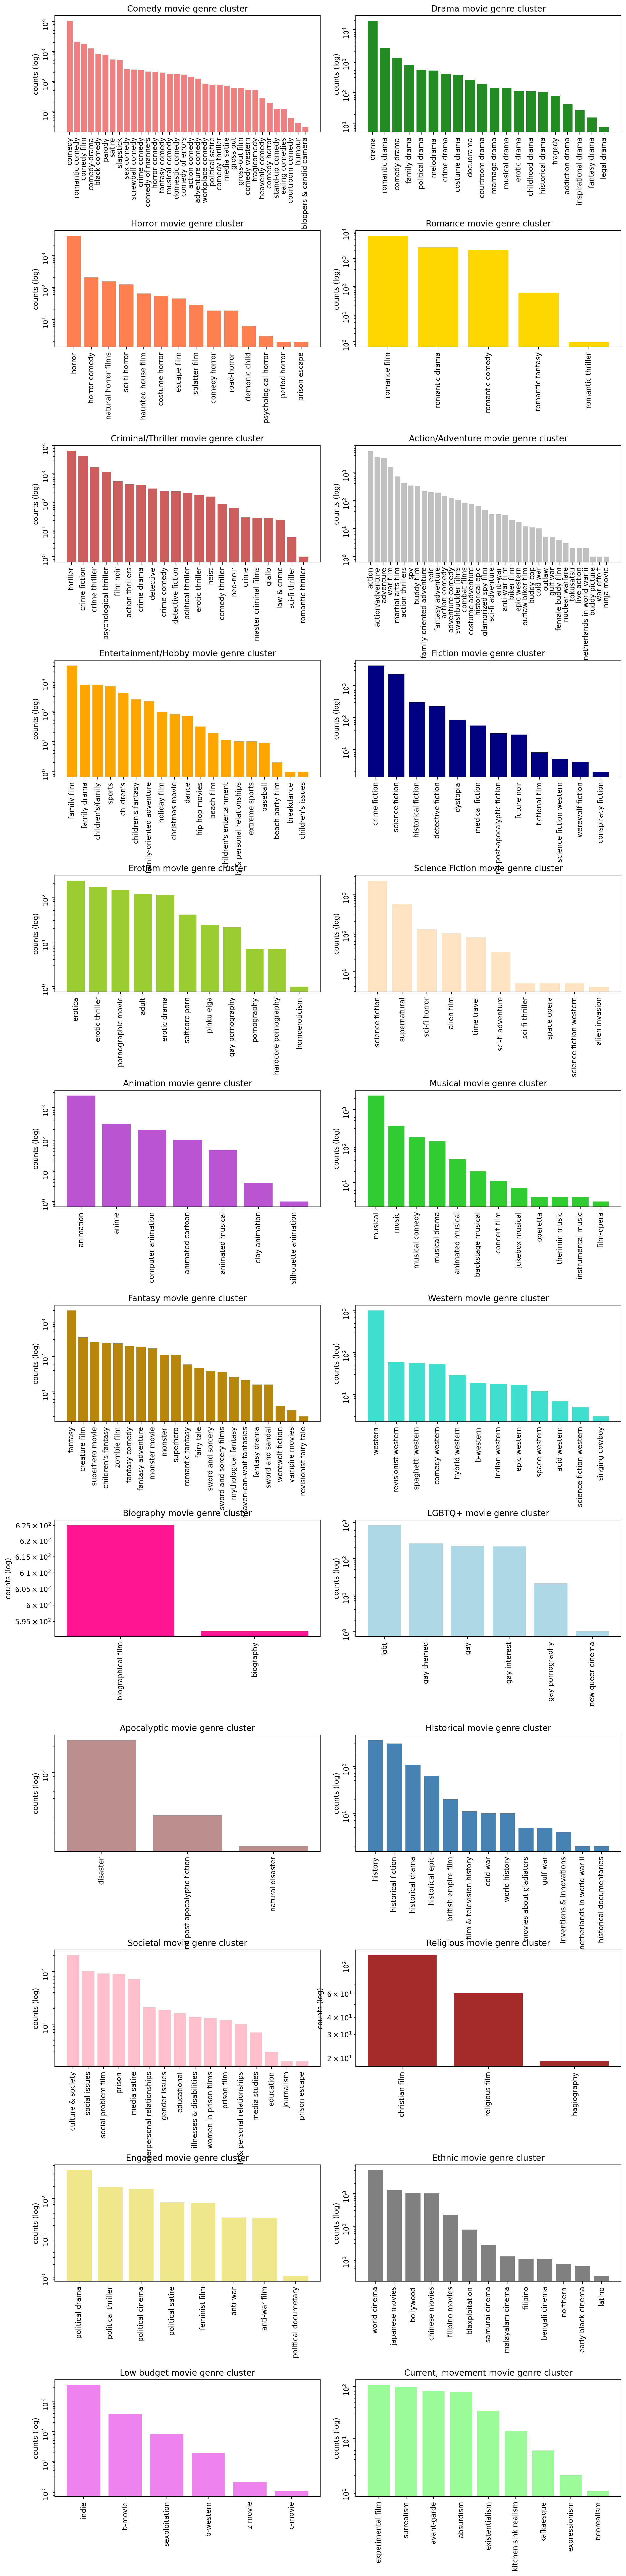

In [18]:
fig, axs = plt.subplots(12, 2, figsize = (12,50), dpi=200)
fig.tight_layout(h_pad=12, w_pad=2)

plot_clusters(0,0, group_comedy, numbers_comedy, cluster_names[0], colors[0])
plot_clusters(0,1, group_drama, numbers_drama, cluster_names[1], colors[1])
plot_clusters(1,0, group_horror, numbers_horror, cluster_names[2], colors[2])
plot_clusters(1,1, group_romance, numbers_romance, cluster_names[3], colors[3])
plot_clusters(2,0, group_criminal, numbers_criminal, cluster_names[4], colors[4])
plot_clusters(2,1, group_action_adv, numbers_action_adv, cluster_names[5], colors[5])
plot_clusters(3,0, group_entert_hobb, numbers_entert_hobb, cluster_names[6], colors[6])
plot_clusters(3,1, group_fiction, numbers_fiction, cluster_names[7], colors[7])
plot_clusters(4,0, group_erotism, numbers_erotism, cluster_names[8], colors[8])
plot_clusters(4,1, group_scifi, numbers_scifi, cluster_names[9], colors[9])
plot_clusters(5,0, group_animation, numbers_animation, cluster_names[10], colors[10])
plot_clusters(5,1, group_musical, numbers_musical, cluster_names[11], colors[11])
plot_clusters(6,0, group_fantasy, numbers_fantasy, cluster_names[12], colors[12])
plot_clusters(6,1, group_western, numbers_western, cluster_names[13], colors[13])
plot_clusters(7,0, group_biography, numbers_biography, cluster_names[14], colors[14])
plot_clusters(7,1, group_queer, numbers_queer, cluster_names[15], colors[15])
plot_clusters(8,0, group_apocalypse, numbers_apocalypse, cluster_names[16], colors[16])
plot_clusters(8,1, group_history, numbers_hystory, cluster_names[17], colors[17])
plot_clusters(9,0, group_society, numbers_society, cluster_names[18], colors[18])
plot_clusters(9,1, group_religion, numbers_religion, cluster_names[19], colors[19])
plot_clusters(10,0, group_engaged, numbers_engaged, cluster_names[20], colors[20])
plot_clusters(10,1, group_world, numbers_world, cluster_names[21], colors[21])
plot_clusters(11,0, group_lowbud, numbers_lowbud, cluster_names[22], colors[22])
plot_clusters(11,1, group_ism, numbers_ism, cluster_names[23], colors[23])

plt.show()

Now we visualized which genres were present in each cluster, we visualize the distribution of these clusters across movies. Again, these clusters may not be fully representative of the entire movie set. But it is sufficient for a broad analysis.

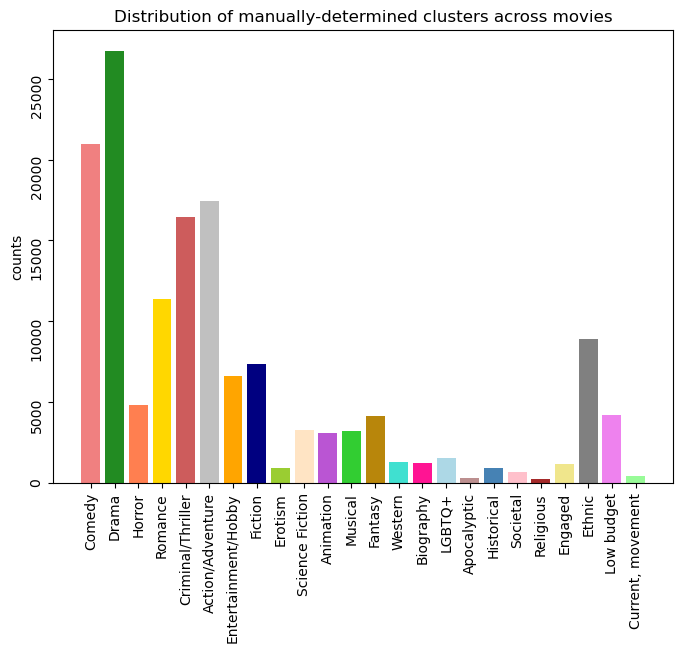

In [19]:
plt.figure(figsize=(8,6), dpi=100)
cluster_counts = [sum(numbers_comedy), sum(numbers_drama), sum(numbers_horror), sum(numbers_romance), sum(numbers_criminal),\
                  sum(numbers_action_adv), sum(numbers_entert_hobb), sum(numbers_fiction), sum(numbers_erotism), sum(numbers_scifi),\
                  sum(numbers_animation), sum(numbers_musical), sum(numbers_fantasy), sum(numbers_western), sum(numbers_biography),\
                  sum(numbers_queer), sum(numbers_apocalypse), sum(numbers_hystory), sum(numbers_society), sum(numbers_religion),\
                  sum(numbers_engaged), sum(numbers_world), sum(numbers_lowbud), sum(numbers_ism)]
plt.bar(cluster_names, cluster_counts, color=colors) 
plt.tick_params(labelrotation=90)
plt.ylabel('counts')
plt.title('Distribution of manually-determined clusters across movies')
plt.show()

### 2.3.4 Words polarity <a id='2.3.4'></a>

Here we want to create 2 additional columns in `movies` indicating the count of positive and negative terms present in plot summaries. We make an intersection between each plot words list and each list of positive or negative words. The positive and negative lists of words are created from online text documents using the get function, the missing values and the title are filtered to get the relevant terms only. 

In [ ]:
# Count of the different negative and positive words
positive_txt = requests.get('https://ptrckprry.com/course/ssd/data/positive-words.txt').text
negative_txt = requests.get('https://ptrckprry.com/course/ssd/data/negative-words.txt').text

def parse_str(s):
    return list(filter(lambda x:x[0]!=';', list(filter(None, s.split("\n")))))

In [ ]:
movies['plot_num_positive']= movies.Plot.apply(lambda x : len(set(parse_str(positive_txt)) & set(RegexpTokenizer(r'\w+').tokenize(x.lower()))))
movies['plot_num_negative']= movies.Plot.apply(lambda x : len(set(parse_str(negative_txt)) & set(RegexpTokenizer(r'\w+').tokenize(x.lower()))))

movies[['plot_num_positive','plot_num_negative']].head(3)

#### Visualization

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
fig.tight_layout(pad=2)
axs[0].hist(movies.plot_num_negative,bins=40,log=True)
axs[0].set_title('Distribution of negative words across movies')
axs[0].set_xlabel('Number negative words')
axs[0].set_ylabel('Counts (log)')

axs[1].hist(movies.plot_num_positive,bins=40,log=True)
axs[1].set_title('Distribution of positive words across movies')
axs[1].set_xlabel('Number of positive words')
axs[1].set_ylabel('Counts (log)')

plt.show()

We observe that most movies use mainly a relatively small number of positive and negative words. Indeed, the distribution is the highest between 0 and 10 words. The main part use 40 or less positive words and 80 or less negative words.  

A deeper anaysis could be done across genres or countries instead of movies. We will let this for Milestone3.

In [ ]:
plt.figure(figsize=(9,7))
plt.scatter(movies.plot_num_negative, movies.plot_num_positive, s=10)
plt.title('Relationship between number of negative words and number of \npositive words in plot summaries')
plt.xlabel('Number of negative words')
plt.ylabel('Number of positive words')
plt.show()

We observe an approximative linear trend : few negative words used correspond to few positive words used, and a lot of negative words correspond to a lot of positive words. However, most movies use a small/an average number of both positive and negative words.  

Again, this analysis will be further explored with genres and countries in Milestone3.

In [ ]:
print('Linear association between count of negative words and count of positive words across plot summaries:')
print(stats.pearsonr(movies.plot_num_negative, movies.plot_num_positive))

Since we have a Pearson's r value of 0.72, there is a relatively strong significant linear correlation between number of negative and positive words.

### 2.3.5 Metascore preliminary visualization <a id='2.3.5'></a>

#### Statistics

In [ ]:
movies.metascore.describe()

In [ ]:
plt.figure(figsize=(9,6))
movies.metascore.hist(bins=100)
plt.title('Distribution of metascores across all movies')
plt.xlabel('Score')
plt.ylabel('Counts')
plt.show()

The metascores distribution looks like a Gaussian distribution. We see some score are never given to movies, at regular intervals!

### 2.3.6 WordCloud <a id='2.3.6'></a>

In [ ]:
docs = plot_summaries.Plot.tolist()
d = " ".join(docs)

clap = np.array(Image.open("data/clap.png"))

# Create a word cloud image
wc = WordCloud(background_color="white", max_words=500, mask=clap,
               stopwords=STOPWORDS, contour_width=3, contour_color='black', colormap="Greys")

# Generate a wordcloud
wc.generate(d)

# store to file
wc.to_file("data/clap_wc.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Saving augmented `movies` dataset

In [ ]:
movies.to_pickle('data/movies_aug_withMetascores.pkl')

In [ ]:
movies = pd.read_pickle('data/movies_aug_withMetascores.pkl')

# 3. Topic Extraction 

## 3.1 LDA <a id='3.1'></a>

### 3.1.1 Data preparation <a id='3.1.1'></a>

#### Prepare bi-grams and tri-grams

In [ ]:
tokens = plot_summaries['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [ ]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

### 3.1.2 Implementation <a id='3.1.2'></a>

In [ ]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

### 3.1.3 Model evaluation <a id='3.1.3'></a>

(by checking how many topics a word exists in)

In [ ]:
topics_ = dict()
for i,topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=20):
    topics_[i]=topic

In [ ]:
"""
Counts for each word the number of topics that include it
"""
def count_words(topics_):
    counts = dict()
    for i in topics_:
        for word in topics_[i]:
            if word[0] in counts:
                counts[word[0]]+=1
            else:
                counts[word[0]]=1
    return counts

def takeSecond(elem):
    return elem[1]

In [ ]:
counts = count_words(topics_)
repeated_words = [(k,v) for k,v in counts.items() if v>=4]
repeated_words.sort(reverse=True, key = takeSecond)
repeated_words

### 3.1.4 Resulting topics <a id='3.1.4'></a>

In [ ]:
for i in topics_:
    message = "Topic {} : ".format(i) 
    words = str([k for (k,v) in topics_[i]])
    print(message+words)
    print()

### 3.1.5 Topic Visualizations <a id='3.1.5'></a>

Unfortunately, since the plot is interactive when we push the notebook to github it disappears. Hopefully, by milestone 3 we can find a way to host it in a github page. In the meantime, you can find a [screenshot](https://github.com/epfl-ada/ada-2022-project-adaccord/blob/main/topic_visualiation.png) of it in our root repository.

In [ ]:
%matplotlib inline
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### 3.1.6 Assigning topics to movies <a id='3.1.6'></a>

In [ ]:
def most_probable_topic(possible_topics):
    possible_topics.sort(reverse=True, key = takeSecond)
    return possible_topics[0][0]

In [ ]:
chosen_topics = list()
for plot in tqdm(corpus):
    possible_topics = lda_model[plot]
    chosen_topic = most_probable_topic(possible_topics)
    chosen_topics.append(chosen_topic)

chosen_topics = np.array(chosen_topics)

In [ ]:
topics_df = pd.DataFrame(chosen_topics, columns = ["Topic"]) #Rename this to Topic_LDA

topics_df["Index"] = topics_df.index

display(topics_df.head())

In [ ]:
plot_summaries["Index"] = plot_summaries.index

plot_summaries = plot_summaries.merge(topics_df, left_on="Index", right_on="Index").drop(columns=["Index"])

In [ ]:
plot_summaries[["WikiMovieID", "Plot", "Topic"]].head() # Can merge again with movies 

#### Saving augmented `movies`

In [ ]:
merging_cols = list(plot_summaries.columns.difference(movies.columns)) + ["WikiMovieID"]
movies = movies.merge(plot_summaries[merging_cols], how="left", on="WikiMovieID")

In [ ]:
os.makedirs('data', exist_ok=True)  
movies.to_pickle('data/movies_aug_lda.pkl')

In [ ]:
movies = pd.read_pickle('data/movies_aug_lda.pkl')

## 3.2 BERTopic

[BERTopic](https://maartengr.github.io/BERTopic/index.html) is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. We will use this model to extract once more topics for each movie plots. The reason we repeat this process twice is so we can compare the results between them and by doing so verify them. In the end we will hopefully find a way to merge our results into a more concrete topic prediction.

### 3.2.1 Data preparation <a id='3.2.1'></a>

BERTopic requires different preparation than LDA. We begin with creating a list of documents where each document is the plot for a movie. Then, we tokenize each document and remove stopwords, punctuations and the names found in [2.1.6](#2.1.6).

In [ ]:
# List of docs
docs = movies[~movies.Plot.isna()].Plot.tolist()

# List of punctuation marks
punctuations = list()
for punctuation in string.punctuation:
    punctuations.append(punctuation)

# Stopwords to use
stop_words = list(set(stopwords.words('english'))) + punctuations + names

# Tokenization : List of Lists of Tokens
docs_tokenized = [word_tokenize(doc) for doc in docs]

# Removing the stopwords
filtered_docs = list()
for doc in tqdm(docs_tokenized):
    filtered_doc = " ".join([w.lower() for w in doc if not w.lower() in stop_words])
    filtered_docs.append(filtered_doc)

### 3.2.2 Implementation <a id='3.2.2'></a>

BERT is a transformer-based machine learning technique which is unfortunately computationally intensive. Therefore, we decided to execute it in google colab to utilise the provided gpu. The instructions followed there are the same as the ones portrayed in this notebook. We then saved the model and its predictions. The model can be found in this [drive](https://drive.google.com/drive/folders/1pUw3DCFzGdlNXRTiX8NZgG0wjSsQYbkZ)

In [ ]:
#model = BERTopic(language="english")
#topics, probs = model.fit_transform(filtered_docs)

### 3.2.3 Model Evaluation <a id='3.2.3'></a>

We saved our model form cloud using `pickle` and the equivalent command given by the `bertopic` [library](https://maartengr.github.io/BERTopic/index.html#common). However when we try to load them we get the following error message : *RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU*. For the moment, we can't solve this problem so we will import our results directly. The commands used in google colab to get these results are provided too but they are commented.

In [ ]:
#model = BERTopic.load('models/BERTopic')
#model = pickle.load(open('models/bert_model', 'rb'))

### 3.2.4 Predictions <a id='3.2.4'></a>

In [ ]:
bert_predictions = pd.read_pickle('predictions/bert_predictions.pkl')

bert_predictions.rename(columns={"Topic":"BERT"}, inplace=True)

### 3.2.5 Topic Visualizations <a id='3.2.5'></a>

Labels for the top 10 most common topics.

In [ ]:
#bert_topics = model.generate_topic_labels()

bert_topics = pd.read_pickle('predictions/bert_topics.pkl')
bert_topics = pd.DataFrame(bert_topics, columns = ["Bert_Topic"])
bert_topics.head(10)

### 3.2.6 Assigning topics to movies <a id='3.2.6'></a>

In [ ]:
movies = movies.merge(bert_predictions, how="left", on="WikiMovieID")
movies[["Plot", "BERT"]].head()

In [ ]:
os.makedirs('data', exist_ok=True)  
movies.to_pickle('data/movies_aug_bert.pkl')

---

# ? Topic evolution through time (not sure where i should put this)

In [160]:
movies["year"] = pd.to_datetime(movies.ReleaseDate, errors="coerce").dt.year
movies["five_year_period"] = movies.year//5*5

# A lot of the ReleaseDate are not filled in the initial dataset which leads to NaT (and eventually NaN) values when converting to datetime
movies_with_year = movies[~movies.year.isna()]
print("We could extract the year of the release date for {:.2f}% of the movies".format(len(movies_with_year)/len(movies)*100))

We could extract the year of the release date for 93.80% of the movies


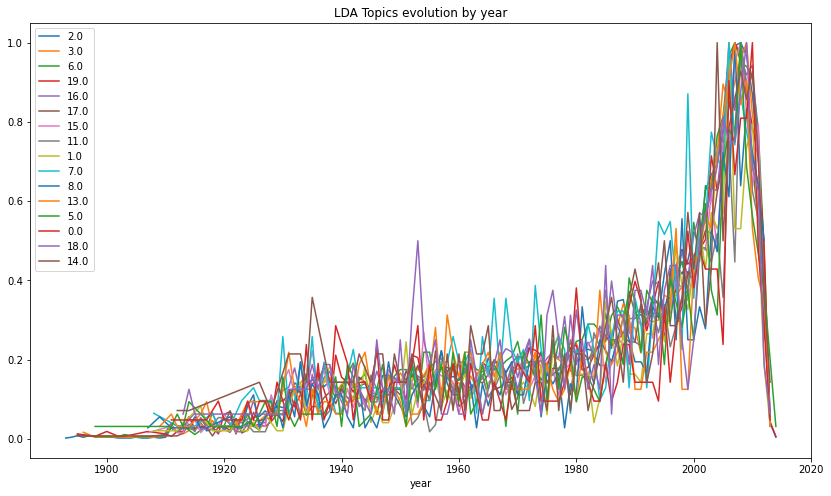

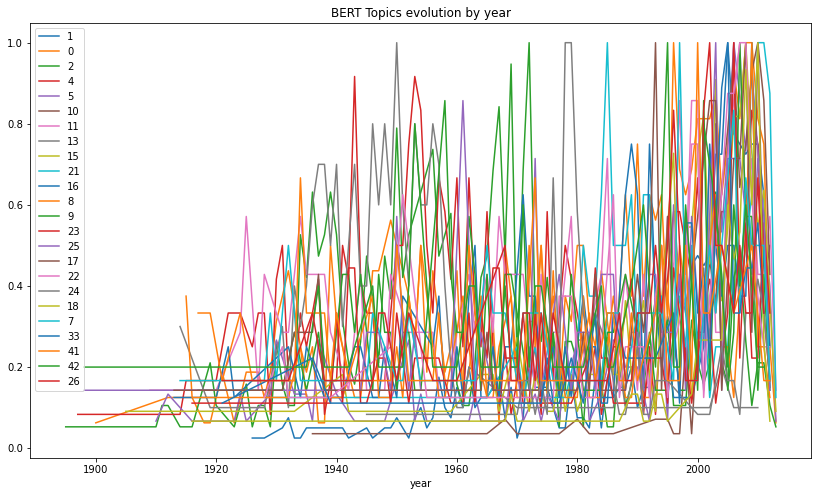

In [153]:
# Unique BERT topics with at least 100 movies assigned
topics_LDA = movies["Topic"].value_counts(dropna=True) 
topics_LDA = topics_LDA[topics_LDA>100].index.tolist()

fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["year"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by year")
fig = plt.legend()
fig = plt.show()

# Unique BERT topics with at least 100 movies assigned
topics_BERT = movies["BERT"].value_counts(dropna=False) 
topics_BERT = topics_BERT[topics_BERT>100].index.tolist()
## -1 goes to unclassfied movies
topics_BERT.remove(-1)

fig = plt.figure(figsize=(14,8))
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["year"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by year")
fig = plt.legend()
fig = plt.show()

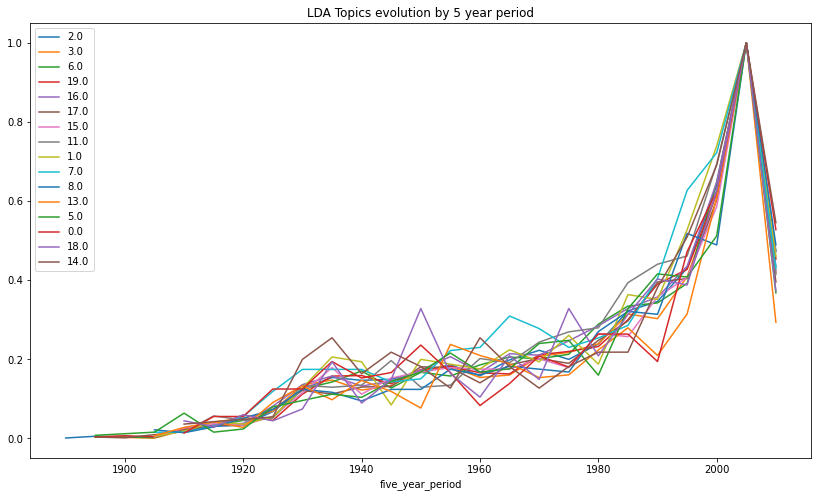

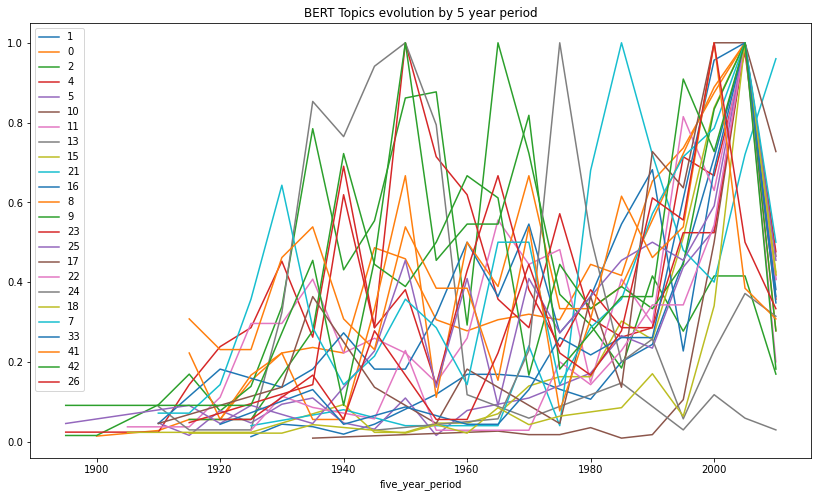

In [165]:
fig = plt.figure(figsize=(14,8))
for topic in topics_LDA:
    temp = movies_with_year[movies_with_year.Topic==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("LDA Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

fig = plt.figure(figsize=(14,8)) 
for topic in topics_BERT:
    temp = movies_with_year[movies_with_year.BERT==topic].groupby(["five_year_period"]).size()
    temp = temp/temp.max()   
    fig = temp.plot(label=topic)
fig = plt.title("BERT Topics evolution by 5 year period")
fig = plt.legend()
fig = plt.show()

Last graph actually could be useful to draw some results. Now it doesn't show (so i'll have to make it show somehow) but if you plot just 1 topic (instead of all of them) you can see that for a few topics there was an interest eirther for a few decades and then it died out or the other way around. Depending on which topics these are (still a number i have to get real tags/names) it could be interesting. 

---

# Removing names using POS-tagging

In [6]:
movies = pd.read_pickle('data/movies_aug_bert.pkl')

In [8]:
movies.columns

Index(['WikiMovieID', 'FreeMovieID', 'Title', 'ReleaseDate', 'Revenue',
       'Runtime', 'Languages', 'Countries', 'Genres', 'Plot', 'lang',
       'words_punc', 'sentences', 'tokens_sentences', 'POS_tokens',
       'tokens_sentences_lemmatized', 'tokens', 'ReleaseDate_',
       'year_last_digits', 'metascore', 'plot_num_sentences', 'plot_num_words',
       'plot_num_dot', 'plot_num_coma', 'plot_num_interrogation',
       'plot_num_exclamation', 'plot_num_percentage', 'plot_num_semicolon',
       'plot_num_colon', 'plot_top_ten_tokens', 'clean_top_ten_tokens',
       'plot_num_positive', 'plot_num_negative', 'Topic', 'BERT'],
      dtype='object')

In [112]:
def find_names(pos_tags):
    names = []
    for sentence in pos_tags:
        names.extend([word.lower() for (word, pos) in sentence if pos =='NNP'])
    
    return names

movies["names"] = movies.POS_tokens.progress_apply(find_names)
movies["tokens_no_names"] = [list(filter(lambda x : x not in names, tokens)) for names, tokens in zip(movies.names, movies.tokens)]


movies[["tokens", "POS_tokens", "names", "tokens_no_names"]]

100%|██████████████████████████████████████████████████████████████████████████| 42174/42174 [00:01<00:00, 36699.72it/s]


tokens  \
0      [set, second, half, century, film, depict, mar...   
1      [series, murder, woman, throughout, arizona, d...   
2      [upper, class, housewife, becomes, frustrated,...   
3      [every, hundred, year, evil, morgana, return, ...   
4      [artist, work, cab, driver, side, hard, time, ...   
...                                                  ...   
42169  [plot, film, open, great, western, express, sp...   
42170  [former, national, oceanic, atmospheric, admin...   
42171  [plot, film, follow, year, life, irish, travel...   
42172  [story, place, year, super, dimension, fortres...   
42173  [movie, teenage, girl, horror, movie, watch, t...   

                                              POS_tokens  \
0      [[(Set, NN), (in, IN), (the, DT), (second, JJ)...   
1      [[(A, DT), (series, NN), (of, IN), (murders, N...   
2      [[(Eva, NNP), (,, ,), (an, DT), (upper, JJ), (...   
3      [[(Every, DT), (hundred, CD), (years, NNS), (,...   
4      [[(Adam, NNP), (,, ,), (a, DT), (San, NNP), (F...   
...                                                  ...   
42169  [[({, (), ({, (), (plot, NN), (}, )), (}, )), ...   
42170  [[(Two, CD), (former, JJ), (National, NNP), (O...   
42171  [[({, (), ({, (), (No, DT), (plot, NN), (}, ))...   
42172  [[(The, DT), (story, NN), (takes, VBZ), (place...   
42173  [[(The, DT), (movie, NN), (is, VBZ), (about, I...   

                                                   names  \
0      [mars, melanie, ballard, sergeant, jericho, de...   
1      [arizona, detective, charles, mendoza, paul, w...   
2      [eva, yvonne, eva, johns, eva, eva, chris, chris]   
3      [morgana, fingall, merlin, young, ben, clark, ...   
4      [adam, san, nina, kate, nina, kate, nina, adam...   
...                                                  ...   
42169  [box, tunnel, cornwall, herbert, edna, truro, ...   
42170   [national, oceanic, atmospheric, administration]   
42171                                                 []   
42172  [super, dimension, fortress, macross, ii, orig...   
42173                                           [wisher]   

                                         tokens_no_names  
0      [set, second, half, century, film, depict, pla...  
1      [series, murder, woman, throughout, distinctiv...  
2      [upper, class, housewife, becomes, frustrated,...  
3      [every, hundred, year, evil, return, claim, ta...  
4      [artist, work, cab, driver, side, hard, time, ...  
...                                                  ...  
42169  [plot, film, open, great, western, speed, rout...  
42170  [former, scientist, investigate, mass, strandi...  
42171  [plot, film, follow, year, life, irish, travel...  
42172  [story, place, year, cd, booklet, eighty, year...  
42173  [movie, teenage, girl, horror, movie, watch, t...  

[42174 rows x 4 columns]

In [116]:
# You can use this to check the differences (filtering done) for each row : 
row = 7
set(movies.tokens[row])-set(movies.tokens_no_names[row])

{'daily', 'planet', 'superman', 'thanks'}

# 4. Sentiment analysis <a id='4'></a>

## 4.1 Positive-Negative-Neutral sentiments

In [13]:
#Quick check 
movies.head()

WikiMovieID FreeMovieID                      Title ReleaseDate     Revenue  \
0       975900   /m/03vyhn             Ghosts of Mars  2001-08-24  14010832.0   
1      9363483  /m/0285_cd           White Of The Eye        1987         NaN   
2       261236   /m/01mrr1          A Woman in Flames        1983         NaN   
3     18998739  /m/04jcqvw  The Sorcerer's Apprentice        2002         NaN   
4      6631279   /m/0gffwj                Little city  1997-04-04         NaN   

   Runtime           Languages                   Countries  \
0     98.0  [English Language]  [United States of America]   
1    110.0  [English Language]            [United Kingdom]   
2    106.0   [German Language]                   [Germany]   
3     86.0  [English Language]              [South Africa]   
4     93.0  [English Language]  [United States of America]   

                                              Genres  \
0  [Thriller, Science Fiction, Horror, Adventure,...   
1  [Thriller, Erotic thriller, Psychological thri...   
2                                            [Drama]   
3    [Family Film, Fantasy, Adventure, World cinema]   
4  [Romantic comedy, Ensemble Film, Comedy-drama,...   

                                                Plot  ...  \
0  Set in the second half of the 22nd century, th...  ...   
1  A series of murders of rich young women throug...  ...   
2  Eva, an upper class housewife, becomes frustra...  ...   
3  Every hundred years, the evil Morgana  returns...  ...   
4  Adam, a San Francisco-based artist who works a...  ...   

  plot_num_exclamation plot_num_percentage plot_num_semicolon plot_num_colon  \
0                    0                   1                  0              0   
1                    0                   0                  1              0   
2                    0                   0                  0              0   
3                    0                   0                  0              0   
4                    0                   0                  0              0   

                                 plot_top_ten_tokens  \
0  [(ballard, 8), (miner, 5), (team, 4), (human, ...   
1  [(gun, 4), (quarry, 4), (sound, 3), (echo, 3),...   
2  [(scene, 4), (look, 3), (money, 3), (romantic,...   
3  [(year, 3), (evil, 3), (hundred, 2), (morgana,...   
4  [(break, 4), (relationship, 2), (woman, 2), (m...   

                                clean_top_ten_tokens plot_num_positive  \
0  [ballard, miner, team, human, martian, sergean...                 2   
1  [gun, quarry, sound, echo, head, away, abandon...                15   
2  [scene, look, money, romantic, gigolo, slowly,...                11   
3  [year, evil, hundred, morgana, intend, world, ...                 4   
4  [break, relationship, woman, move, begin, affa...                 4   

  plot_num_negative Topic  BERT  
0                18   1.0    -1  
1                22   2.0     0  
2                14   5.0    -1  
3                 4   6.0    -1  
4                 7   2.0    -1  

[5 rows x 35 columns]

In [9]:
#Initialize the analyzer. Typically used for data from social media (short sentences).
analyzer = SentimentIntensityAnalyzer()

The sentiment score consits of four values. Neutral, positive and negative sum to one. The final score is obtained by thresholding the compound value (e.g. +/-0.05). The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

The more Compound score closer to +1, the higher the positivity of the text.
We can now observe the distributions of sentiment across all sentences in plot summaries.

In [14]:
#nlp = spacy.load('en_core_web_sm') was used to get the sentences

movies['scores'] = movies['Plot'].apply(lambda plot: analyzer.polarity_scores(plot)) 
movies['positive_score'] = movies['scores'].apply(lambda score_dict: score_dict['pos']) 
movies['negative_score'] = movies['scores'].apply(lambda score_dict: score_dict['neg']) 
movies['neutral_score'] = movies['scores'].apply(lambda score_dict: score_dict['neu']) 
movies['compound_score'] = movies['scores'].apply(lambda score_dict: score_dict['compound']) 

In [ ]:
movies[['scores','positive_score','negative_score', 'neutral_score','compound_score']].head()

scores  positive_score  \
0  {'neg': 0.15, 'neu': 0.786, 'pos': 0.065, 'com...           0.065   
1  {'neg': 0.197, 'neu': 0.718, 'pos': 0.085, 'co...           0.085   
2  {'neg': 0.065, 'neu': 0.835, 'pos': 0.1, 'comp...           0.100   
3  {'neg': 0.131, 'neu': 0.776, 'pos': 0.092, 'co...           0.092   
4  {'neg': 0.108, 'neu': 0.804, 'pos': 0.089, 'co...           0.089   

   negative_score  neutral_score  compound_score  
0           0.150          0.786         -0.9913  
1           0.197          0.718         -0.9983  
2           0.065          0.835          0.9604  
3           0.131          0.776         -0.8885  
4           0.108          0.804         -0.7097

## 4.2 Multi-sentiments analysis

NRCLex will measure emotional affect from a body of text. Affect dictionary contains approximately 27,000 words, and is based on the National Research Council Canada (NRC) affect lexicon (see link below) and the NLTK library's WordNet synonym sets. ([See documentation](https://pypi.org/project/NRCLex/))

Emotional affects measured include the following:

- fear
- anger
- anticipation
- trust
- surprise
- positive
- negative
- sadness
- disgust
- joy

In [20]:
from nrclex import NRCLex

In [21]:
movies['multi_scores'] = movies['Plot'].progress_apply(lambda plot: NRCLex(plot).affect_frequencies) 

100%|████████████████████████████████████████████████████████████████████████████| 42178/42178 [12:48<00:00, 54.88it/s]


In [69]:
movies['multi_scores'][0]

{'fear': 0.16296296296296298,
 'anger': 0.13333333333333333,
 'anticip': 0.0,
 'trust': 0.1111111111111111,
 'surprise': 0.02962962962962963,
 'positive': 0.1111111111111111,
 'negative': 0.2,
 'sadness': 0.08888888888888889,
 'disgust': 0.08148148148148149,
 'joy': 0.02962962962962963,
 'anticipation': 0.05185185185185185}

Idea for visualization:  
-Topic: Bubble with topics and words inside (see Green Peace)  
-Evolution over time: heatpmap(Green Peace)  
-Projection plot of topic (Green Peace)  


### Plot sentiment analysis

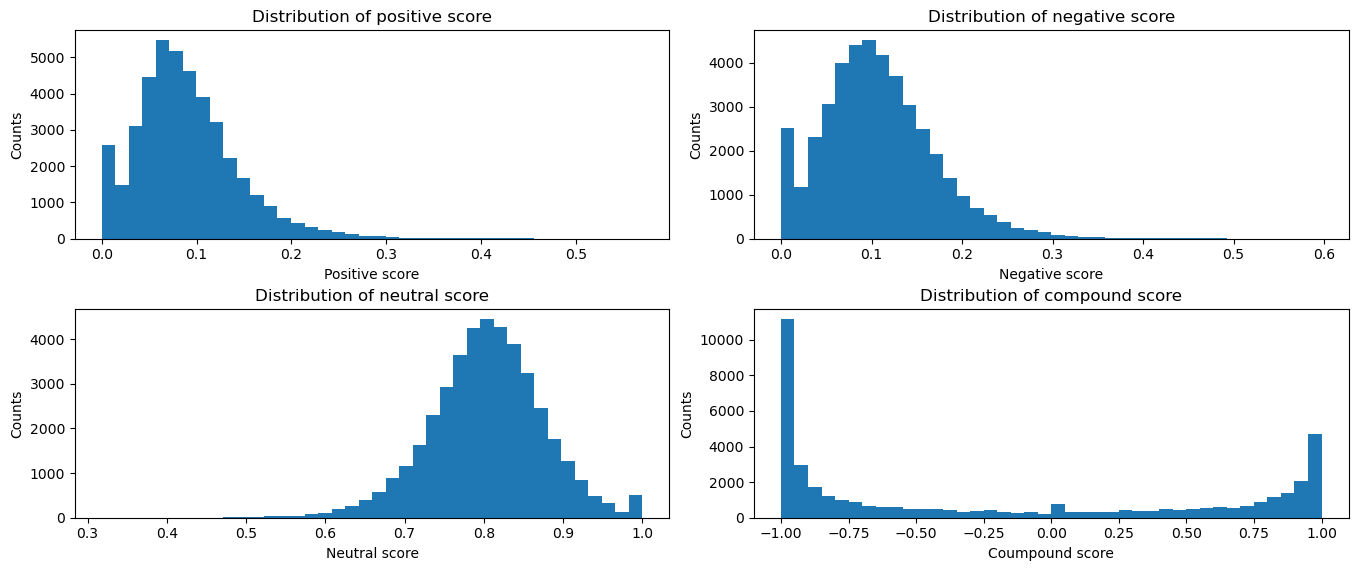

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))
fig.tight_layout(pad=3)
axs[0,0].hist(movies.positive_score,bins=40)
axs[0,0].set_title('Distribution of positive score')
axs[0,0].set_xlabel('Positive score')
axs[0,0].set_ylabel('Counts')

axs[0,1].hist(movies.negative_score,bins=40)
axs[0,1].set_title('Distribution of negative score')
axs[0,1].set_xlabel('Negative score')
axs[0,1].set_ylabel('Counts')

axs[1,0].hist(movies.neutral_score,bins=40)
axs[1,0].set_title('Distribution of neutral score')
axs[1,0].set_xlabel('Neutral score')
axs[1,0].set_ylabel('Counts')

axs[1,1].hist(movies.compound_score,bins=40)
axs[1,1].set_title('Distribution of compound score')
axs[1,1].set_xlabel('Coumpound score')
axs[1,1].set_ylabel('Counts')

plt.show()

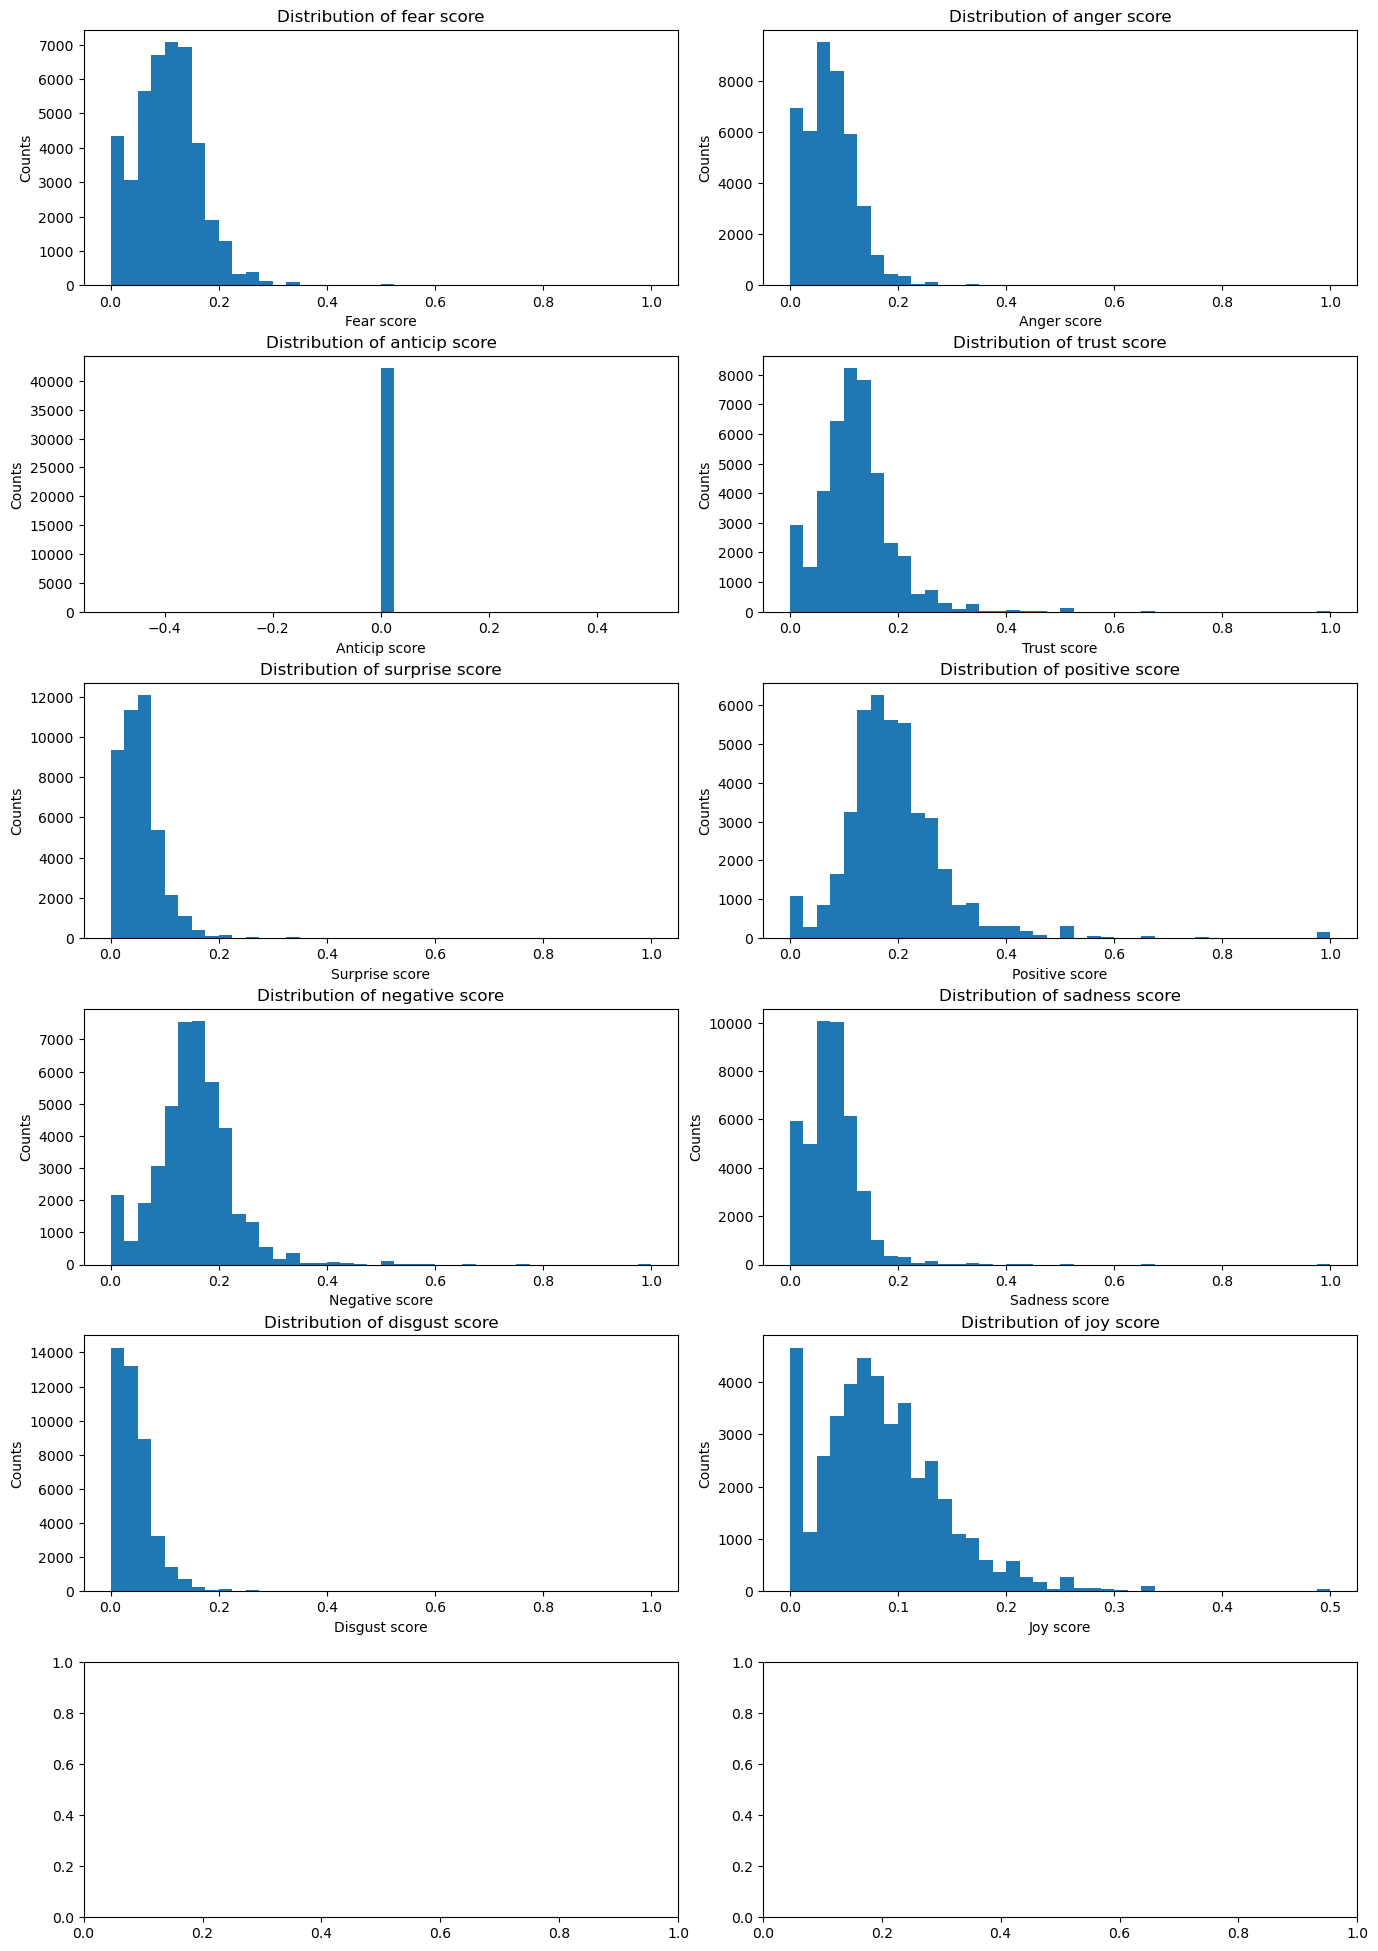

In [78]:
fig, axs = plt.subplots(6, 2, figsize=(14,20))
fig.tight_layout(pad=3)
axs[0,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['fear']),bins=40)
axs[0,0].set_title('Distribution of fear score')
axs[0,0].set_xlabel('Fear score')
axs[0,0].set_ylabel('Counts')

axs[0,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['anger']),bins=40)
axs[0,1].set_title('Distribution of anger score')
axs[0,1].set_xlabel('Anger score')
axs[0,1].set_ylabel('Counts')

axs[1,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['anticip']),bins=40)
axs[1,0].set_title('Distribution of anticip score')
axs[1,0].set_xlabel('Anticip score')
axs[1,0].set_ylabel('Counts')

axs[1,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['trust']),bins=40)
axs[1,1].set_title('Distribution of trust score')
axs[1,1].set_xlabel('Trust score')
axs[1,1].set_ylabel('Counts')

axs[2,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['surprise']),bins=40)
axs[2,0].set_title('Distribution of surprise score')
axs[2,0].set_xlabel('Surprise score')
axs[2,0].set_ylabel('Counts')

axs[2,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['positive']),bins=40)
axs[2,1].set_title('Distribution of positive score')
axs[2,1].set_xlabel('Positive score')
axs[2,1].set_ylabel('Counts')

axs[3,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['negative']),bins=40)
axs[3,0].set_title('Distribution of negative score')
axs[3,0].set_xlabel('Negative score')
axs[3,0].set_ylabel('Counts')

axs[3,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['sadness']),bins=40)
axs[3,1].set_title('Distribution of sadness score')
axs[3,1].set_xlabel('Sadness score')
axs[3,1].set_ylabel('Counts')

axs[4,0].hist(movies.multi_scores.apply(lambda score_dict: score_dict['disgust']),bins=40)
axs[4,0].set_title('Distribution of disgust score')
axs[4,0].set_xlabel('Disgust score')
axs[4,0].set_ylabel('Counts')

axs[4,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['joy']),bins=40)
axs[4,1].set_title('Distribution of joy score')
axs[4,1].set_xlabel('Joy score')
axs[4,1].set_ylabel('Counts')

#axs[5,1].hist(movies.multi_scores.apply(lambda score_dict: score_dict['anticipation']),bins=40)
#axs[5,1].set_title('Distribution of anticipation score')
#axs[5,1].set_xlabel('Anticipation score')
#axs[5,1].set_ylabel('Counts')

plt.show()

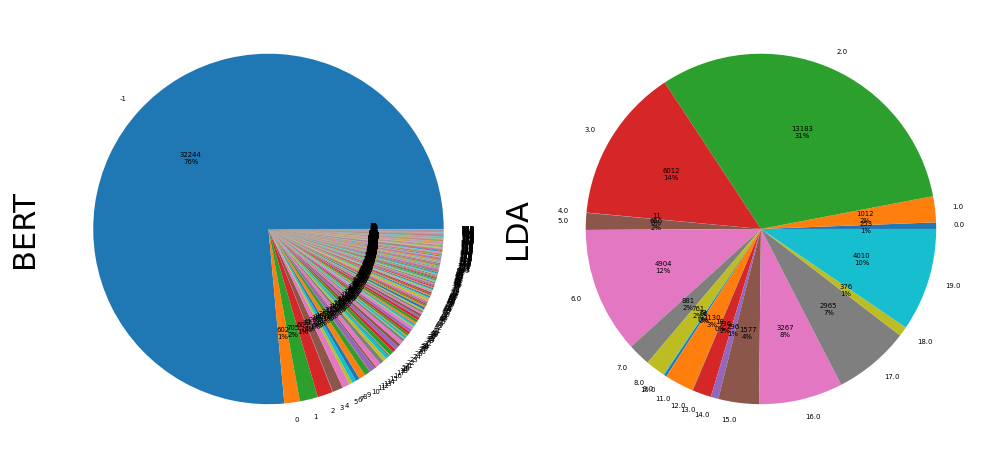

In [71]:
def label_function(val):
    return f'{val / 100 * len(movies):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
movies.groupby('BERT').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax1)
movies.groupby('Topic').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 5}, ax=ax2)
ax1.set_ylabel('BERT', size=22)
ax2.set_ylabel('LDA', size=22)
plt.tight_layout()
plt.show()

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\clara\anaconda3\envs\ada\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



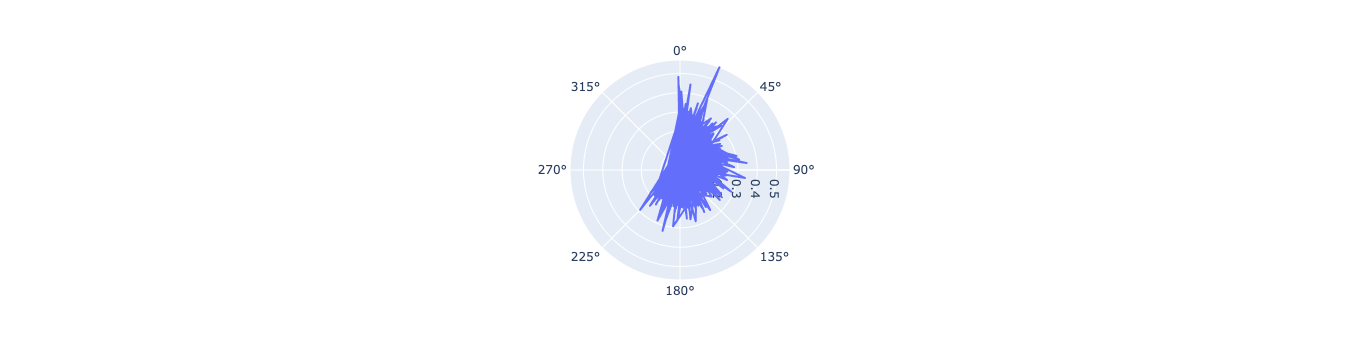

In [77]:
#https://plotly.com/python/radar-chart/
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.express as px
import pandas as pd
fig = px.line_polar(movies, r='positive_score', theta='BERT', line_close=True)
fig.show()